In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

# 为了在图表中显示中文/日文，需要设置字体
# 如果您的环境没有安装 japanize_matplotlib，可能会显示乱码
# 建议安装: !pip install japanize-matplotlib
try:
    import japanize_matplotlib
except ImportError:
    # 如果没有安装，尝试设置通用字体 (Mac: 'Hiragino Sans', Windows: 'MS Gothic')
    plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Heiti TC']
# 1. 加载数据 (使用您提供的样例数据)
df = pd.read_csv('games.csv', encoding='shift_jis')

# 检查数据加载情况
print(f"数据行数: {len(df)}")
df.head(3)

数据行数: 4382


,game_id,year_id,game_kind_id,game_kind_name,game_date,game_year,game_month,stadium_id,stadium_name,home_team_league_id,...,game_ended_time,game_time,game_delayed_time,attendance,home_team_score,away_team_score,inning,top_bottom_id,top_bottom_name,game_end_status
0,2021000095,30018,1,セ・リーグ公式戦,2021-03-26,2021,3,1,東京ドーム,1,...,21:16:00,03:28:00,NaN,9991.0,8,7,9,2,裏,NaN
1,2021000096,30018,1,セ・リーグ公式戦,2021-03-26,2021,3,2,神宮,1,...,21:08:00,03:36:00,NaN,9984.0,3,4,9,2,裏,NaN
2,2021000097,30018,1,セ・リーグ公式戦,2021-03-26,2021,3,30014,マツダスタジアム,1,...,20:57:00,02:54:00,NaN,16452.0,6,7,9,2,裏,NaN


# 第一步：数据预处理 (Feature Engineering)
原始数据包含基础信息，我们需要提取有助于商业分析的“特征”。

- 日期处理：转换格式，提取“星期几”。
- 时段分类：根据开赛时间判断是“日场(Day)”还是“夜场(Night)”。
- 对战组合：创建“主队 vs 客队”的标签。

In [14]:
# 1. 日期格式转换
df['game_date'] = pd.to_datetime(df['game_date'])

# 2. 提取星期几 (0=周一, 6=周日) 并映射为中文/日文
weekday_map = {0: '周一', 1: '周二', 2: '周三', 3: '周四', 4: '周五', 5: '周六', 6: '周日'}
df['weekday_num'] = df['game_date'].dt.dayofweek
df['weekday_name'] = df['weekday_num'].map(weekday_map)

# 3. 提取开赛小时 并 定义 Day/Night
# 逻辑：17:00 (含) 以后开始的算 Night Game
df['start_hour'] = pd.to_datetime(df['game_started_time'], format='%H:%M:%S').dt.hour
df['time_category'] = df['start_hour'].apply(lambda x: '夜场 (Night)' if x >= 17 else '日场 (Day)')

# 4. 创建对战组合标签
df['matchup'] = df['home_team_name'] + ' vs ' + df['away_team_name']

# 查看处理后的特定列
df[['game_date', 'weekday_name', 'start_hour', 'time_category', 'matchup', 'attendance']].head()

,game_date,weekday_name,start_hour,time_category,matchup,attendance
0,2021-03-26,周五,17,夜场 (Night),巨人 vs DeNA,9991.0
1,2021-03-26,周五,17,夜场 (Night),ヤクルト vs 阪神,9984.0
2,2021-03-26,周五,18,夜场 (Night),広島 vs 中日,16452.0
3,2021-03-26,周五,16,日场 (Day),楽天 vs 日本ハム,14559.0
4,2021-03-26,周五,17,夜场 (Night),西武 vs オリックス,9599.0


# 第二步：多维度分析 (Data Analysis)
2.1 时间维度的分析 (When)
- 分析星期几和比赛时段对观众人数的影响。

In [15]:
# 按星期几计算平均观众人数
weekday_avg = df.groupby('weekday_name')['attendance'].mean().sort_values(ascending=False)
print("【按星期几平均人数】\n", weekday_avg)

# 按 Day/Night 计算平均观众人数
time_avg = df.groupby('time_category')['attendance'].mean()
print("\n【按时段平均人数】\n", time_avg)

【按星期几平均人数】
 weekday_name
周一    28020.048951
周六    27831.667497
周日    27565.329975
周五    25423.733236
周四    23865.410882
周三    23538.178317
周二    23280.295588
Name: attendance, dtype: float64

【按时段平均人数】
 time_category
夜场 (Night)    24675.500165
日场 (Day)      27471.130468
Name: attendance, dtype: float64


2.2 球队/球场维度的分析 (Who & Where)
- 分析哪个主场的上座率最高。

In [16]:
# 按主队球场计算平均观众人数
stadium_avg = df.groupby(['stadium_name', 'home_team_name'])['attendance'].mean().sort_values(ascending=False).reset_index()
stadium_avg

,stadium_name,home_team_name,attendance
0,東京ドーム,ソフトバンク,41979.500000
1,東京ドーム,西武,41472.000000
2,東京ドーム,楽天,40593.000000
3,東京ドーム,ロッテ,39129.500000
4,みずほPayPay,ソフトバンク,39045.207143
...,...,...,...
66,釧路,日本ハム,6656.500000
67,旭川,日本ハム,6636.000000
68,帯広,日本ハム,6498.500000
69,東京ドーム,DeNA,4898.833333


# 第三步：可视化 (Visualization)
用图表讲故事。这里使用 Seaborn 和 Matplotlib。

C:\Users\Ene\AppData\Local\Temp\ipykernel_28516\1499496946.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday_name', y='attendance', data=df, order=order_days, palette='viridis')
C:\Users\Ene\AppData\Local\Temp\ipykernel_28516\1499496946.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_category', y='attendance', data=df, palette='Set2')
C:\Users\Ene\AppData\Local\Temp\ipykernel_28516\1499496946.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attendance', y='stadium_name', data=df, palette='coolwarm')


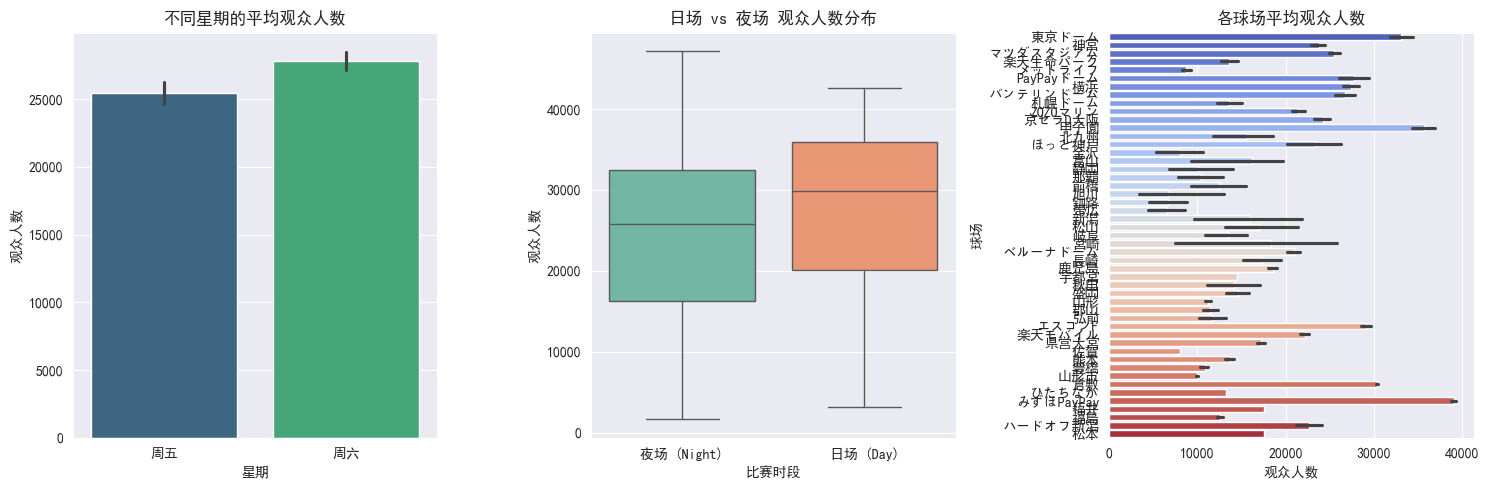

In [17]:
# 设置画布大小
plt.figure(figsize=(15, 5))

# 图表 1: 星期几 vs 观众人数 (柱状图)
plt.subplot(1, 3, 1)
# 确保星期几按顺序排列 (这里仅有周五和周六的数据，所以只显示这两个)
order_days = ['周五', '周六']
sns.barplot(x='weekday_name', y='attendance', data=df, order=order_days, palette='viridis')
plt.title('不同星期的平均观众人数')
plt.xlabel('星期')
plt.ylabel('观众人数')

# 图表 2: 日场 vs 夜场 (箱线图 - 展示分布)
plt.subplot(1, 3, 2)
sns.boxplot(x='time_category', y='attendance', data=df, palette='Set2')
plt.title('日场 vs 夜场 观众人数分布')
plt.xlabel('比赛时段')
plt.ylabel('观众人数')

# 图表 3: 各球场动员力排行 (横向条形图)
plt.subplot(1, 3, 3)
sns.barplot(x='attendance', y='stadium_name', data=df, palette='coolwarm')
plt.title('各球场平均观众人数')
plt.xlabel('观众人数')
plt.ylabel('球场')

plt.tight_layout()
plt.show()

## 对战热力图
分析哪些对战组合最热门。

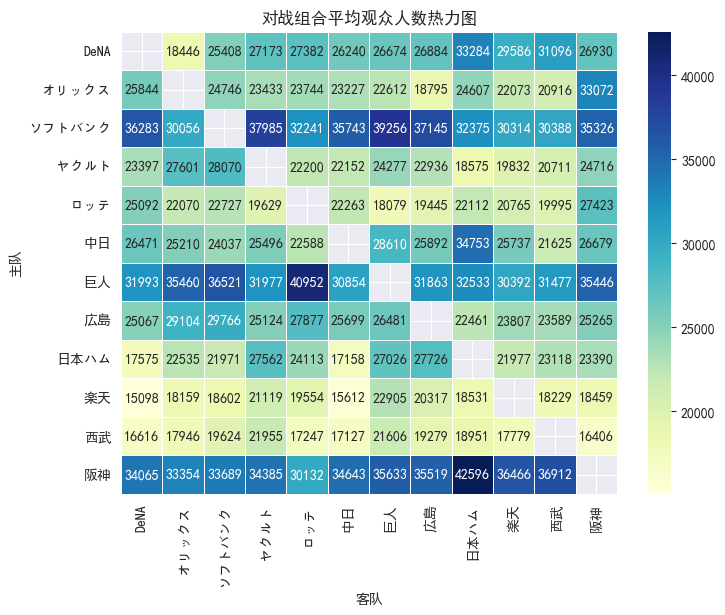

In [18]:
# 创建透视表：行=主队，列=客队，值=平均观众人数
pivot_table = df.pivot_table(index='home_team_name', columns='away_team_name', values='attendance', aggfunc='mean')

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)
plt.title('对战组合平均观众人数热力图')
plt.xlabel('客队')
plt.ylabel('主队')
plt.show()

# 第四步：商业洞察与建议 (Actionable Insights)
在此步骤中，我们基于上面的图表输出结论。(以下结论基于您提供的 9 条样本数据，实际分析需使用全量数据)

In [19]:
def generate_insights(df):
    insights = []

    # 1. 星期分析
    fri_avg = df[df['weekday_name']=='周五']['attendance'].mean()
    sat_avg = df[df['weekday_name']=='周六']['attendance'].mean()
    if sat_avg > fri_avg:
        insights.append(f"📅 **赛程策略**：周六的平均观众数 ({sat_avg:.0f}) 高于周五 ({fri_avg:.0f})。周末效应明显。")

    # 2. 时段分析
    day_avg = df[df['time_category']=='日场 (Day)']['attendance'].mean()
    night_avg = df[df['time_category']=='夜场 (Night)']['attendance'].mean()
    insights.append(f"☀️/🌙 **时段策略**：日场平均 {day_avg:.0f} 人，夜场平均 {night_avg:.0f} 人。")

    # 3. 异常值/特定发现 (基于2021年背景)
    max_attendance = df['attendance'].max()
    if max_attendance < 17000:
        insights.append("⚠️ **特殊背景注意**：数据中最大观众数仅为 16,479 (广岛)，且东京巨蛋限制在 10,000 以下。这明显反映了 2021 年 COVID-19 的入场限制政策。建议分析时引入「满座率」概念，因为绝对人数受政策封顶影响。")

    return insights

print("【自动生成的商业洞察】")
for i in generate_insights(df):
    print(i)

【自动生成的商业洞察】
📅 **赛程策略**：周六的平均观众数 (27832) 高于周五 (25424)。周末效应明显。
☀️/🌙 **时段策略**：日场平均 27471 人，夜场平均 24676 人。
